In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


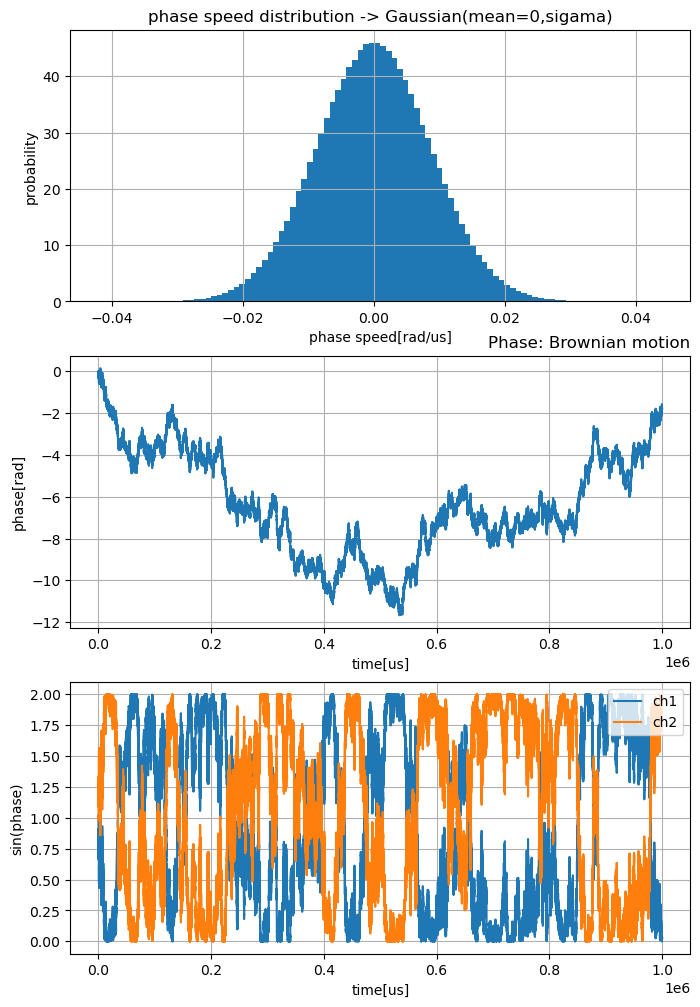

In [39]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi # deg/us -> rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [58]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())

def fb_weight(measure, time_exposure):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=3*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered

    
def simu_phase(phase_speed,time_exposure,method):
    """
    method 1: instant feedback  
    method 2: average feedback  
    method 3: average feedback with iteration  
    method 4: weighted feedback  
    """
    
    time_iter1=3 # method 3 迭代参数，每隔time_iter1个exposure再进行一次测量
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M=np.zeros_like(phase_speed_M)
    phase_measure_M=np.zeros(phase_speed_M.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M[i]=np.cumsum(phase_speed_M[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M[i],2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M[i]=get_phase_from_count(ch1_measure,ch2_measure)
        
        
        if i<(sig_ch1_exposure.shape[0]-1):
            if method==1:
                phase_speed_M[i+1,0]-=phase_measure_M[i] # 反馈到下一个exposure的起始点
            if method==2 or method==3:
                c0=phase_measure_M[i]
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1]-=phase_fb_M/time_exposure # 均匀反馈到下一个exposure时间
            if method==4:
                c0=fb_weight(phase_measure_M[i],time_exposure*(2/3)*(2/3))
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1,0]-=phase_fb_M # 均匀反馈到下一个exposure时间

        if method==3:
            if i%time_iter1==0 and i!=0:
                ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i].sum())
                ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i].sum())
                phase_measure_M_it1=get_phase_from_count(ch1_measure,ch2_measure)
                c0=get_phase_from_count(ch1_measure,ch2_measure)#/100
                phase_fb_M=np.sign(phase_measure_M_it1)*np.abs(c0)
                phase_speed_M[i:i+time_iter1]-=phase_fb_M/time_exposure/time_iter1
        
        if method==5:
                ##-- 反馈
            if i<(sig_ch1_exposure.shape[0]-1):
                c0=fb_weight(phase_measure_M[i],time_exposure=time_exposure*(1/3)*(1/3))
                phase_speed_M[i+1,0]-=c0#/time_exposure # 反馈到下一个exposure
            
                ##-- 迭代反馈 one 10*time_exposure
                if i%time_iter1==0 and i!=0:
                    phaseit1=phase_M[i,-1]+phase_speed_M[i+1,0]
                    suffix1=get_sig_from_phase(phaseit1,1)
                    suffix2=get_sig_from_phase(phaseit1,2)
                    ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
                    ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
                    phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
                    phase_measure_it1_M5[i]=phase_measure_M5_it1
                    c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*(1.5/3)*(1.5/3))
                    phase_speed_M[i+1,1]-=c0

        phase_offest=phase_M[i,-1]
    phase_out_M=np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M


In [59]:
np.std(simu_phase(phase_speed,time_exposure=10,method=5))

100%|██████████| 100000/100000 [00:17<00:00, 5625.03it/s]


0.07954538269436795

In [60]:
df=pd.DataFrame(columns=['time_exposure','phase_var_M1','phase_var_M4','phase_var_M5'])
time_test=[2,5,10,20,40,50,80,100,200,250,400,500,800]
time_d=[]
phase_var_M1=[]
phase_var_M4=[]
phase_var_M5=[]
for time_exposure in time_test:
    time_d.append(time_exposure)
    #phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=1)
    #phase_var_M1.append(np.var(phase_out))
    phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=4)
    phase_var_M4.append(np.var(phase_out))
    phase_out=simu_phase(phase_speed,time_exposure=time_exposure,method=5)
    phase_var_M5.append(np.var(phase_out))
df['time_exposure']=time_d
df['phase_var_M1']=phase_var_M1
df['phase_var_M4']=phase_var_M4
df['phase_var_M5']=phase_var_M5

df

100%|██████████| 1250/1250 [00:00<00:00, 5385.72it/s]


ValueError: Length of values (0) does not match length of index (13)

In [61]:
df['phase_var_M4']=phase_var_M4
df['phase_var_M5']=phase_var_M5

df

,time_exposure,phase_var_M1,phase_var_M4,phase_var_M5
0,2,NaN,0.008543,0.005052
1,5,NaN,0.009323,0.005629
2,10,NaN,0.010017,0.006327
3,20,NaN,0.009991,0.007322
4,40,NaN,0.010205,0.008721
5,50,NaN,0.010276,0.009725
6,80,NaN,0.010525,0.011616
7,100,NaN,0.011110,0.012782
8,200,NaN,0.015415,0.019673
9,250,NaN,0.018396,0.022858


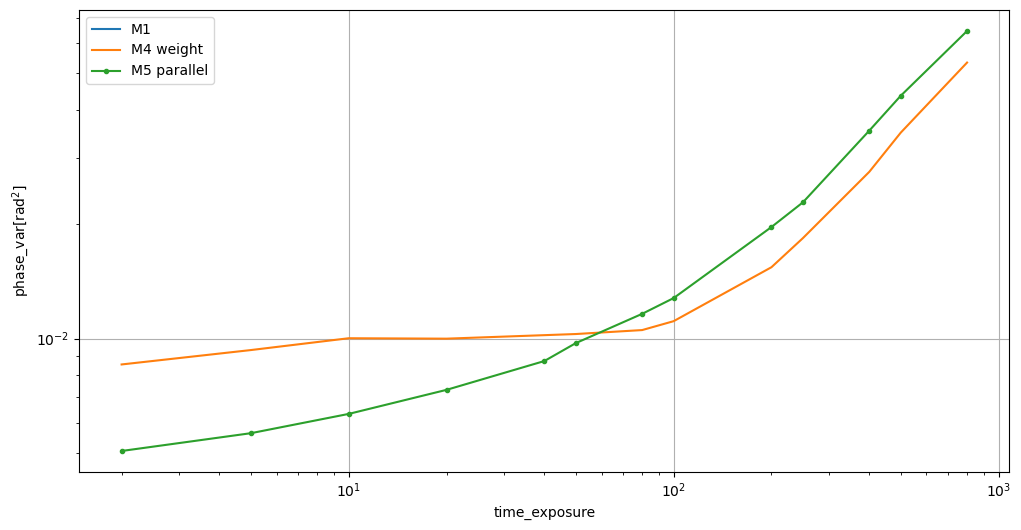

In [62]:
plt.figure(figsize=(12,6))
plt.plot(df['time_exposure'],df['phase_var_M1'],label='M1')
plt.plot(df['time_exposure'],df['phase_var_M4'],label='M4 weight')
plt.plot(df['time_exposure'],df['phase_var_M5'],'.-',label='M5 parallel')
plt.legend() 
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time_exposure')
plt.ylabel('phase_var[rad$^2$]')
plt.show()

In [52]:
df

,time_exposure,phase_var_M1,phase_var_M4,phase_var_M5
0,2,434.578144,0.008543,0.005650
1,5,0.154726,0.009323,0.006428
2,10,0.057768,0.010017,0.007297
3,20,0.027352,0.009991,0.008355
4,40,0.015107,0.010205,0.009667
5,50,0.013161,0.010276,0.010163
6,80,0.011340,0.010525,0.012025
7,100,0.011332,0.011110,0.012661
8,200,0.015539,0.015415,0.019050
9,250,0.018375,0.018396,0.023734


## 根据反馈方向的准确性确定合适的time exposure

### 不同sigma的补偿效果

### 根据补偿时间与残差的关系去选择合适的并行时间